# Title: Simulations for Metrics
### Purpose: Show how metric sims happen
### Author: @mjz



## Global imports and notebook setup here

In [1]:
%matplotlib inline

#------ python libs ----------
import logging
import os
SEP = os.path.sep
import sys
import uuid
import pathlib

#------ notebook libs ----------
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import IPython.display
import numpy as np
import scipy.stats as st
import scipy.special
import pandas as pd

# # bokeh plotting setup
# import bokeh.io
# import bokeh.plotting
# import bokeh.application
# import bokeh.application.handlers
# bokeh.io.output_notebook()
# notebook_url = 'localhost:8888'

#------ data connectors ----------
# -- bq --
from google.cloud import bigquery
# %reload_ext google.cloud.bigquery # %%bigquery df
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_loc # bq_client needs this (svc_acct auth)
# bigquery_client = bigquery.Client(project=proj) # 
# -- influx--
# from influxdb import InfluxDBClient
# from influxdb import DataFrameClient
# client = InfluxDBClient('192.168.0.115', '8086')
# dbs = client.get_list_database()
# -- mongo--
# import pymongo 
# from pymongo import MongoClient
# client = MongoClient('localhost', 27017)
# print(client.list_database_names())


#------ project libs ----------
py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

# Just importing for their flags right now
import py_mulval.py_mulval as py_mulval
import py_mulval.boromir as boromir
import py_mulval.log_util as log_util
import py_mulval.mulpy as mulpy
import py_mulval.metrics as secmet
import py_mulval.attack_graph as attack_graph

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

['/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py']

In [2]:
# Show an attack graph in this notebook
def plot_ag(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

In [3]:
# # Distributions to check, shape constants were taken from the examples on the scipy.stats distribution documentation pages.
# DISTRIBUTIONS = [
#     stats.alpha(a=3.57, loc=0.0, scale=1.0), stats.anglit(loc=0.0, scale=1.0), 
#     stats.arcsine(loc=0.0, scale=1.0), stats.beta(a=2.31, b=0.627, loc=0.0, scale=1.0), 
#     stats.betaprime(a=5, b=6, loc=0.0, scale=1.0), stats.bradford(c=0.299, loc=0.0, scale=1.0),
#     stats.burr(c=10.5, d=4.3, loc=0.0, scale=1.0), stats.cauchy(loc=0.0, scale=1.0), 
#     stats.chi(df=78, loc=0.0, scale=1.0), stats.chi2(df=55, loc=0.0, scale=1.0),
#     stats.cosine(loc=0.0, scale=1.0), stats.dgamma(a=1.1, loc=0.0, scale=1.0), 
#     stats.dweibull(c=2.07, loc=0.0, scale=1.0), stats.erlang(a=2, loc=0.0, scale=1.0), 
#     stats.expon(loc=0.0, scale=1.0), stats.exponnorm(K=1.5, loc=0.0, scale=1.0),
#     stats.exponweib(a=2.89, c=1.95, loc=0.0, scale=1.0), stats.exponpow(b=2.7, loc=0.0, scale=1.0),
#     stats.f(dfn=29, dfd=18, loc=0.0, scale=1.0), stats.fatiguelife(c=29, loc=0.0, scale=1.0), 
#     stats.fisk(c=3.09, loc=0.0, scale=1.0), stats.foldcauchy(c=4.72, loc=0.0, scale=1.0),
#     stats.foldnorm(c=1.95, loc=0.0, scale=1.0), stats.frechet_r(c=1.89, loc=0.0, scale=1.0),
#     stats.frechet_l(c=3.63, loc=0.0, scale=1.0), stats.genlogistic(c=0.412, loc=0.0, scale=1.0),
#     stats.genpareto(c=0.1, loc=0.0, scale=1.0), stats.gennorm(beta=1.3, loc=0.0, scale=1.0), 
#     stats.genexpon(a=9.13, b=16.2, c=3.28, loc=0.0, scale=1.0), stats.genextreme(c=-0.1, loc=0.0, scale=1.0),
#     stats.gausshyper(a=13.8, b=3.12, c=2.51, z=5.18, loc=0.0, scale=1.0), stats.gamma(a=1.99, loc=0.0, scale=1.0),
#     stats.gengamma(a=4.42, c=-3.12, loc=0.0, scale=1.0), stats.genhalflogistic(c=0.773, loc=0.0, scale=1.0),
#     stats.gilbrat(loc=0.0, scale=1.0), stats.gompertz(c=0.947, loc=0.0, scale=1.0),
#     stats.gumbel_r(loc=0.0, scale=1.0), stats.gumbel_l(loc=0.0, scale=1.0),
#     stats.halfcauchy(loc=0.0, scale=1.0), stats.halflogistic(loc=0.0, scale=1.0),
#     stats.halfnorm(loc=0.0, scale=1.0), stats.halfgennorm(beta=0.675, loc=0.0, scale=1.0),
#     stats.hypsecant(loc=0.0, scale=1.0), stats.invgamma(a=4.07, loc=0.0, scale=1.0),
#     stats.invgauss(mu=0.145, loc=0.0, scale=1.0), stats.invweibull(c=10.6, loc=0.0, scale=1.0),
#     stats.johnsonsb(a=4.32, b=3.18, loc=0.0, scale=1.0), stats.johnsonsu(a=2.55, b=2.25, loc=0.0, scale=1.0),
#     stats.ksone(n=1e+03, loc=0.0, scale=1.0), stats.kstwobign(loc=0.0, scale=1.0),
#     stats.laplace(loc=0.0, scale=1.0), stats.levy(loc=0.0, scale=1.0),
#     stats.levy_l(loc=0.0, scale=1.0), stats.levy_stable(alpha=0.357, beta=-0.675, loc=0.0, scale=1.0),
#     stats.logistic(loc=0.0, scale=1.0), stats.loggamma(c=0.414, loc=0.0, scale=1.0),
#     stats.loglaplace(c=3.25, loc=0.0, scale=1.0), stats.lognorm(s=0.954, loc=0.0, scale=1.0),
#     stats.lomax(c=1.88, loc=0.0, scale=1.0), stats.maxwell(loc=0.0, scale=1.0),
#     stats.mielke(k=10.4, s=3.6, loc=0.0, scale=1.0), stats.nakagami(nu=4.97, loc=0.0, scale=1.0),
#     stats.ncx2(df=21, nc=1.06, loc=0.0, scale=1.0), stats.ncf(dfn=27, dfd=27, nc=0.416, loc=0.0, scale=1.0),
#     stats.nct(df=14, nc=0.24, loc=0.0, scale=1.0), stats.norm(loc=0.0, scale=1.0),
#     stats.pareto(b=2.62, loc=0.0, scale=1.0), stats.pearson3(skew=0.1, loc=0.0, scale=1.0),
#     stats.powerlaw(a=1.66, loc=0.0, scale=1.0), stats.powerlognorm(c=2.14, s=0.446, loc=0.0, scale=1.0),
#     stats.powernorm(c=4.45, loc=0.0, scale=1.0), stats.rdist(c=0.9, loc=0.0, scale=1.0),
#     stats.reciprocal(a=0.00623, b=1.01, loc=0.0, scale=1.0), stats.rayleigh(loc=0.0, scale=1.0),
#     stats.rice(b=0.775, loc=0.0, scale=1.0), stats.recipinvgauss(mu=0.63, loc=0.0, scale=1.0),
#     stats.semicircular(loc=0.0, scale=1.0), stats.t(df=2.74, loc=0.0, scale=1.0),
#     stats.triang(c=0.158, loc=0.0, scale=1.0), stats.truncexpon(b=4.69, loc=0.0, scale=1.0),
#     stats.truncnorm(a=0.1, b=2, loc=0.0, scale=1.0), stats.tukeylambda(lam=3.13, loc=0.0, scale=1.0),
#     stats.uniform(loc=0.0, scale=1.0), stats.vonmises(kappa=3.99, loc=0.0, scale=1.0),
#     stats.vonmises_line(kappa=3.99, loc=0.0, scale=1.0), stats.wald(loc=0.0, scale=1.0),
#     stats.weibull_min(c=1.79, loc=0.0, scale=1.0), stats.weibull_max(c=2.87, loc=0.0, scale=1.0),
#     stats.wrapcauchy(c=0.0311, loc=0.0, scale=1.0)
# ]

## Background Info

Sampling from distributions with scipy.stats

In [4]:
matplotlib.rcParams['figure.figsize'] = (8, 4)
matplotlib.style.use('ggplot')


def sample_from_dist(dist='exp', *args, **kwargs):
  if dist=='exp':
    if 'rate' in kwargs.keys() and kwargs['rate']:
      return sample_from_dist_exponential(*args, **kwargs)


def sample_from_dist_exponential(rate=.5):
  return st.expon.rvs(size=10000,scale=0.3)



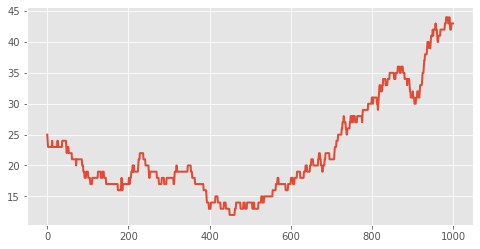

In [5]:
# source https://ipython-books.github.io/131-simulating-a-discrete-time-markov-chain/
N = 100  # maximum population size
a = .5 / N  # birth rate
b = .5 / N  # death rate

nsteps = 1000
x = np.zeros(nsteps)
x[0] = 25


for t in range(nsteps - 1):
  if 0 < x[t] < N - 1:
      # Is there a birth?
      birth = np.random.rand() <= a * x[t]
      # Is there a death?
      death = np.random.rand() <= b * x[t]
      # We update the population size.
      x[t + 1] = x[t] + 1 * birth - 1 * death
  # The evolution stops if we reach $0$ or $N$.
  else:
      x[t + 1] = x[t]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, lw=2)


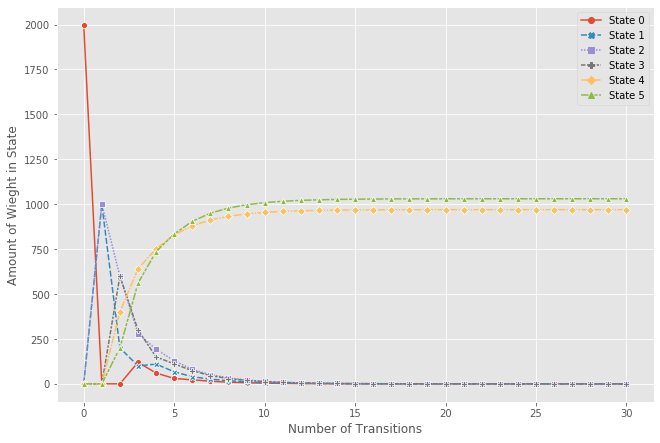

In [9]:
import seaborn as sns
def MarkovChain(state, transition, iterations):
  stateHistory = []
  stateTrack = [state]
  last_state = []
  i = 0
  length = [0]
  convergence = False

  while convergence == False and i < iterations:
      last_state = state
      state = np.dot(state, transition)
      stateTrack.append(list(state))
      i = i + 1
      length.append(i)
      
      if all(last_state == state) == True:
          convergence = True

  return stateTrack, length, state

def PlotMarkov(stateTrack, length, state):
  labels = ['State %d' % i for i in range(len(state))]
  dims =(10.7, 7.27)
  fig, ax = plt.subplots(figsize=dims)
  plt.xlabel('Number of Transitions')
  plt.ylabel('Amount of Wieght in State')
  splot = pd.DataFrame(stateTrack, length, labels)
  sns.lineplot(ax=ax, data = splot, markers=True)

#   results = {'Number of Iterations': 'i','Steady State Vector': state}
#   display(pd.DataFrame(data=results))

state = [2000, 0, 0, 0, 0, 0]

transition = [
        
            [0.0, 0.5, 0.5, 0.0, 0.0, 0.0],
            [0.0, 0.2, 0.2, 0.6, 0.0, 0.0],
            [0.0, 0.0, 0.4, 0.0, 0.4, 0.2],
            [0.2, 0.1, 0.0, 0.3, 0.0, 0.4],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
            
                            ]

stateTrack, length, state = MarkovChain(state, transition, 30)
PlotMarkov(stateTrack, length, state)


In [125]:
def normalize_scores_graph1(g, weight='score', strategy=None):
    """ makes cvss scores into probabilities according to [Abraham2014]
    add new edge label 'weighted_score' so return matrix isnt needed here
    this can be done in attack graph too (set edge scores)
    :param weight: the edge labels to normalize
    :return:
    """
    nodetally = {}
    # nodetally['nodes'] = {}
    nodelist = list(nx.topological_sort(g))
    NEW_EDGE_LABEL = 'weighted_score'


    for n in g.nodes():
      # only concerned with outbound probs in this weighting method
      nodetally[n] = {}
      # pprint.pprint(nodetally)

      nodetally[n]['succs_sum'] = 0
      nodetally[n]['succs_count'] = 0
      nodetally[n]['preds_sum'] = 0
      nodetally[n]['preds_count'] = 0

      # i_edges = [((u, v, k), e) for u, v, k, e in g.in_edges(n, keys=True, data=True)]
      o_edges = [((u, v, k), e) for u, v, k, e in g.out_edges(n, keys=True, data=True)]

      for (u, v, k), e in o_edges:
        if weight not in g[u][v][k].keys():
          nodetally[u][v][k][weight] = None
        if g[u][v][k][weight] is not None:
          nodetally[n]['succs_sum'] += g[u][v][k][weight]
        nodetally[n]['succs_count'] += 1

        denom = nodetally[n]['succs_sum']
        for (u, v, k), e in o_edges:
          if weight not in g[u][v][k].keys():
            nodetally[u][v][k][weight] = None
          if g[u][v][k][weight] is not None and g[u][v][k][weight] > 0:
            g[u][v][k]['weighted_score']= g[u][v][k][weight] / denom

    q = nx.adjacency_matrix(g, nodelist, weight=NEW_EDGE_LABEL)
    # print(nodelist, q.todense())
    # return q


In [126]:
from py_mulval import attack_graph
np.set_printoptions(suppress=True)

ag = attack_graph.AttackGraph()
ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'
ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False

reduced_ag = ag.getReducedGraph()
normalize_scores_graph1(reduced_ag, weight='score_orig')
node_list = list(nx.topological_sort(reduced_ag))
# plot_ag(reduced_ag, 'Reduced Attack Graph is the Markov Transition Matrix', )
P_orig = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='score') 
P_normal = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='weighted_score') 

ag.map_scores = 'cvss2time'
reduced_ag = ag.getReducedGraph()
P_mapped = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='score') 
normalize_scores_graph1(reduced_ag, weight='score')
P_mapped_normed = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='weighted_score') 


Q = P_mapped[:-1,:-1]

# print('CVSS weighted:\n', P_orig.todense())

# print('CVSS weighted normalized:\n', P_normal.todense())
print( node_list, '<-node ID\n')
print('CVSS mappped to arrival rates:\n',P_mapped.todense())

# print('CVSS mappped to arrival rates normalized:\n',P_mapped_normed.todense())

# print('Q:\n', Q.todense())

['0', '13', '8', '5', '3', '1'] <-node ID

CVSS mappped to arrival rates:
 [[   0.      1.      0.      0.      0.      0.  ]
 [   0.      0.      1.      0.2     0.      0.  ]
 [   0.      0.      0.   5000.      0.      0.  ]
 [   0.      0.      0.      0.      0.02    0.  ]
 [   0.      0.      0.      0.      0.      5.  ]
 [   0.      0.      0.      0.      0.      0.  ]]


<class 'numpy.ndarray'> [50.  0.  0.  0.  0.  0.]
time:0 attacker state: 0 current_nodeID: 0
time:1 attacker state: 0 current_nodeID: 0
time:2 attacker state: 0 current_nodeID: 0
time:3 attacker state: 0 current_nodeID: 0
time:4 attacker state: 0 current_nodeID: 0
time:5 attacker state: 0 current_nodeID: 0
time:6 attacker state: 0 current_nodeID: 0
time:7 attacker state: 0 current_nodeID: 0
time:8 attacker state: 0 current_nodeID: 0
time:9 attacker state: 0 current_nodeID: 0
time:10 attacker state: 0 current_nodeID: 0
time:11 attacker state: 0 current_nodeID: 0
time:12 attacker state: 0 current_nodeID: 0
time:13 attacker state: 0 current_nodeID: 0
time:14 attacker state: 0 current_nodeID: 0
time:15 attacker state: 0 current_nodeID: 0
time:16 attacker state: 0 current_nodeID: 0
time:17 attacker state: 0 current_nodeID: 0
time:18 attacker state: 0 current_nodeID: 0
time:19 attacker state: 0 current_nodeID: 0
time:20 attacker state: 0 current_nodeID: 0
time:21 attacker state: 0 current_no

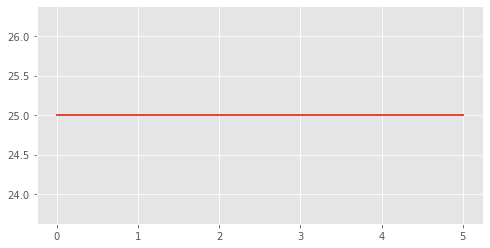

In [133]:
# arrival_rates = [.0002, .02, 1, 5, 50]
# samples_expon = sample_from_dist(dist='exp', rate=50)
# plt.hist(samples_expon, bins=100)
# print(len(samples_expon))
# df = pd.DataFrame(samples_expon)
# print(df.describe())
# st.expon.shape

rows, cols = P_mapped.shape


max_steps = 50
state_at_step = np.zeros(max_steps, dtype=int)
# states[0] correspond to nodes in the attack graph
states = np.zeros(len(node_list)) # x[t]
states[0] = max_steps
print(type(states), states)

# N = 100  # maximum population size
# advance = .5 / N  # birth rate
# b = .5 / N  # death rate

for t in range(max_steps - 1):
  print('time:{} attacker state: {} current_nodeID: {}'.format(t, state_at_step[t], state_at_step[t]))
  if state_at_step[t] != states[len(states)-1]:
#     Does the attacker advance?
    
      
      advance = sample_from_dist(dist='exp', rate=50) 
      print(advance)
    
#         <= a * x[t]
      # Is there a death?
#       death = np.random.rand() <= b * x[t]
      # We update the population size.
#       x[t + 1] = x[t] + 1 * birth - 1 * death
  # The evolution stops if we reach $0$ or $N$.
#   else:
#       x[t + 1] = x[t]
# print(x)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, lw=2)

In [175]:


n_steps = 100
starting_state = 0
current_state = starting_state

state_sequence = [current_state]
for _ in range(n_steps):
    current_state = np.random.choice(state_space, p=transition_matrix[current_state, :])
    state_sequence.append(current_state)
    
plt.figure(figsize=(30, 5))
plt.plot(range(n_steps + 1), state_sequence)
plt.yticks(state_space, state_space_names)
plt.grid()
plt.show()

NameError: name 'state_space' is not defined

<class 'list'>
state: [2000, 0, 0, 0, 0, 0] at time 0
state: [0.0, 1000.0, 1000.0, 0.0, 0.0, 0.0] at time 0
state: [0.0, 200.0, 600.0, 600.0, 400.0, 200.0] at time 0
state: [120.0, 100.0, 280.0, 300.0, 640.0, 560.0] at time 0
state: [60.0, 110.0, 192.0, 150.0, 752.0, 736.0] at time 0
state: [30.0, 67.0, 128.8, 111.0, 828.8, 834.4] at time 0
state: [22.2, 39.5, 79.92, 73.5, 880.32, 904.56] at time 0
state: [14.7, 26.35, 50.97, 45.75, 912.29, 949.94] at time 0
state: [9.15, 17.2, 33.01, 29.54, 932.68, 978.44] at time 0
state: [5.91, 10.97, 21.22, 19.18, 945.88, 996.85] at time 0
state: [3.84, 7.06, 13.63, 12.33, 954.36, 1008.77] at time 0
state: [2.47, 4.56, 8.78, 7.94, 959.82, 1016.43] at time 0
state: [1.59, 2.94, 5.66, 5.12, 963.33, 1021.36] at time 0
state: [1.02, 1.89, 3.65, 3.3, 965.6, 1024.54] at time 0
state: [0.66, 1.22, 2.35, 2.13, 967.05, 1026.59] at time 0
state: [0.43, 0.79, 1.51, 1.37, 967.99, 1027.91] at time 0
state: [0.27, 0.51, 0.98, 0.88, 968.6, 1028.76] at time 0
stat

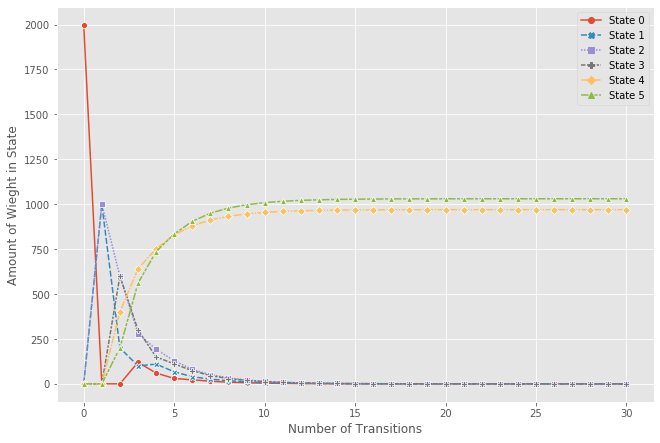

In [101]:
def MarkovChain(state, transition, iterations):
  stateHistory = []
  stateTrack = [state]
  last_state = []
  i = 0
  length = [0]
  convergence = False

  while convergence == False and i < iterations:
      last_state = state
      print('state: {} at time {}'.format([  round(s, 2) for s in state],  t))
      state = np.dot(state, transition)
      stateTrack.append(list(state))
      i = i + 1
      length.append(i)
      
#       if all(last_state == state) == True:
#           convergence = True

  return stateTrack, length, state

def PlotMarkov(stateTrack, length, state):
  labels = ['State %d' % i for i in range(len(state))]
  dims =(10.7, 7.27)
  fig, ax = plt.subplots(figsize=dims)
  plt.xlabel('Number of Transitions')
  plt.ylabel('Amount of Wieght in State')
  splot = pd.DataFrame(stateTrack, length, labels)
  sns.lineplot(ax=ax, data = splot, markers=True)

#   results = {'Number of Iterations': 'i','Steady State Vector': state}
#   display(pd.DataFrame(data=results))

state = [2000, 0, 0, 0, 0, 0]

transition = [
        
            [0.0, 0.5, 0.5, 0.0, 0.0, 0.0],
            [0.0, 0.2, 0.2, 0.6, 0.0, 0.0],
            [0.0, 0.0, 0.4, 0.0, 0.4, 0.2],
            [0.2, 0.1, 0.0, 0.3, 0.0, 0.4],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
            
                            ]
print(type(transition))
stateTrack, length, state = MarkovChain(state, transition, 30)
PlotMarkov(stateTrack, length, state)


In [119]:


import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import *

def compute_Q_d(a, s, q0=0):
    # a: no of arrivals in a period
    # s: no of services at start of a period
    d = np.zeros_like(a)  # departures
    Q = np.zeros_like(a)  # queue lengths
    Q[0] = q0  # starting level of the queue
    for i in range(1, len(a)):
        d[i] = min(Q[i - 1], s[i])
        Q[i] = Q[i - 1] + a[i] - d[i]

    return Q, d

def cdf(a):
    y = range(1, len(a) + 1)
    y = [yy / len(a) for yy in y]  # normalize
    x = sorted(a)
    return x, y

def KS(X, F): #Equality test that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test)
    # Compute the Kolmogorov-Smirnov statistic where
    # X are the data points
    # F is the theoretical distribution
    support, y = cdf(X)
    y_theo = np.array([F.cdf(x) for x in support])
    return np.max(np.abs(y - y_theo))



250.0
0.07401771863414919


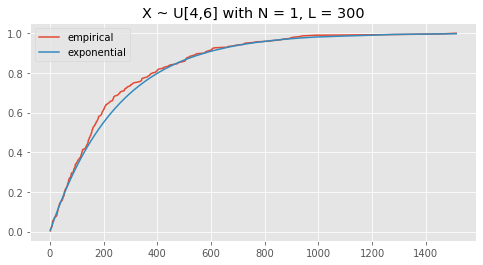

In [122]:
def plot_distributions(x, y, N, L, dist, dist_name):
    # plot the empirical cdf and the theoretical cdf in one figure
    plt.title("X ~ {} with N = {}, L = {}".format(dist_name, N, L))
    plt.plot(x, y, label="empirical")
    plt.plot(x, dist.cdf(x), label="exponential")
    plt.legend()
    plt.show()
    
def simulation_4():
    N = 1  # number of customers
    L = 300

    labda = 1.0 / 5  # lambda is a function in python. Hence we write labda
    E = expon(scale=50.0 / labda)
    print(E.mean()) # to check that we chose the right scale
    a = E.rvs(L)

    print(KS(a, E))
    x, y = cdf(a)
    dist_name = "U[4,6]"

    plot_distributions(x, y, N, L, E, dist_name)

simulation_4()

In [123]:

def AGMarkov(ag):
#   np.set_printoptions(suppress=True)
#   ag = attack_graph.AttackGraph()
#   ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
#   ag.name = 'small_enterprise'
#   ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
#   ag.PLOT_INTERMEDIATE_GRAPHS = False
#   ag.map_scores = 'cvss2time'

  reduced_ag = ag.getReducedGraph()
  node_list = list(nx.topological_sort(reduced_ag))

  # reduced_ag = ag.getReducedGraph()
  normalize_scores_graph1(reduced_ag, weight='score')
  node_list = list(nx.topological_sort(reduced_ag))
  print(node_list)
  if '0' in node_list:
    node_list.pop(0)
  print(node_list)
  P_orig = nx.adjacency_matrix(reduced_ag, nodelist=node_list, weight='score_orig')
  P_normal = nx.adjacency_matrix(reduced_ag, nodelist=node_list, weight='weighted_score')

  ag.map_scores = 'cvss2time'
  reduced_ag = ag.getReducedGraph()
  P_mapped = nx.adjacency_matrix(reduced_ag, nodelist=node_list, weight='score')

  # print('CVSS weighted:\n', P_orig.todense())
  tmatrix = np.asarray(P_normal.todense()).tolist()
#   print('CVSS weighted normalized {}:\n{}'.format(type(tmatrix), tmatrix))
#   for row in tmatrix:
#         print(type(row), row)
  # print(node_list, '<-node IDs\n')
  # print('CVSS mappped to arrival rates:\n', P_mapped.todense())


  steps = 2000
  state = np.zeros(len(node_list), dtype=int)
  state[0] = 2000
#   print(state)

#   return(MarkovChain(state, P_normal, 30))
  return(MarkovChain(state, tmatrix, 30))

def MarkovChain(state, transition, iterations):
  stateHistory = []
  stateTrack = [state]
  last_state = []
  i = 0
  length = [0]
  convergence = False

  while convergence == False and i < iterations:
      last_state = state
      print('state: {} at time {}'.format([  round(s, 2) for s in state],  t))
      print('dot\n',  np.dot(state, transition))
      state = np.dot(state, transition)
      stateTrack.append(list(state))
      i = i + 1
      length.append(i)
      
#       if all(last_state == state) == True:
#           convergence = True

  return stateTrack, length, state

stateTrack, length, state = AGMarkov(ag)
print(state)
# df = pd.DataFrame(stateTrack)
# df.head()
0# PlotMarkov(stateTrack, length, state)

['0', '13', '8', '5', '3', '1']
['13', '8', '5', '3', '1']
state: [2000, 0, 0, 0, 0] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.         1666.66666667  333.33333333    0.            0.        ]
state: [0.0, 1666.67, 333.33, 0.0, 0.0] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.            0.         1666.66666667  333.33333333    0.        ]
state: [0.0, 0.0, 1666.67, 333.33, 0.0] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.            0.            0.         1666.66666667  333.33333333]
state: [0.0, 0.0, 0.0, 1666.67, 333.33] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.            0.            0.            0.         1666.66666667]
state: [0.0, 0.0, 0.0, 0.0, 1666.67] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [0. 0. 0. 0. 0.]
state: [0.0, 0.0, 0.0, 0.0, 0.0] at time <scipy.stats._continuous_di

0

['0', '13', '8', '5', '3', '1']
['13', '8', '5', '3', '1']
state: [2000, 0, 0, 0, 0] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.         1666.66666667  333.33333333    0.            0.        ]
state: [0.0, 1666.67, 333.33, 0.0, 0.0] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.            0.         1666.66666667  333.33333333    0.        ]
state: [0.0, 0.0, 1666.67, 333.33, 0.0] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.            0.            0.         1666.66666667  333.33333333]
state: [0.0, 0.0, 0.0, 1666.67, 333.33] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [   0.            0.            0.            0.         1666.66666667]
state: [0.0, 0.0, 0.0, 0.0, 1666.67] at time <scipy.stats._continuous_distns.t_gen object at 0x7f51c8c69b00>
dot
 [0. 0. 0. 0. 0.]
state: [0.0, 0.0, 0.0, 0.0, 0.0] at time <scipy.stats._continuous_di

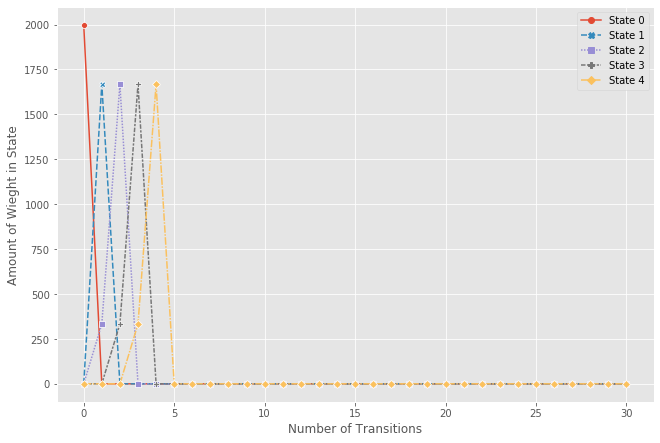

In [124]:
from py_mulval import attack_graph
ag = attack_graph.AttackGraph()
ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'
ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False

reduced_ag = ag.getReducedGraph()
normalize_scores_graph1(reduced_ag, weight='score_orig')
node_list = list(nx.topological_sort(reduced_ag))
# plot_ag(reduced_ag, 'Reduced Attack Graph is the Markov Transition Matrix', )
P_orig = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='score') 
P_normal = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='weighted_score') 

ag.map_scores = 'cvss2time'
reduced_ag = ag.getReducedGraph()
P_mapped = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='score') 
normalize_scores_graph1(reduced_ag, weight='score')
P_mapped_normed = nx.adjacency_matrix(reduced_ag, nodelist=node_list,  weight='weighted_score') 

stateTrack, length, state = AGMarkov(ag)
# print(AGMarkov(ag))
PlotMarkov(stateTrack, length, state)

## Another Section


### subsection

## Conclusion